In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [5]:
#from google.colab import drive

#rive.mount('/content/drive')
#path =path = '/content/drive/MyDrive/nmchr_lab/Subjects/inclined/new/right_based/'


In [14]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [15]:
# ---------------------------------------------------- #
#  -> Provide Number of Trainning Subj and Test Subj.  #
#  -> List all the file name per each subj.            #
# ---------------------------------------------------- #

no_subj_train = 4
no_subj_test  = 1

sub1_file = ['TH\TH_4_I_r.xlsx', 'TH\TH_2_I_r.xlsx', 'TH\TH_3_I_r.xlsx']
sub2_file = ['JJ\JJ_4_I_r.xlsx', 'JJ\JJ_6_I_r.xlsx', 'JJ\JJ_7_I_r.xlsx']
sub3_file = ['SD\SD_1_I_r.xls', 'SD\SD_4_I_r.xls', 'SD\SD_2_I_r.xls', 'SD\SD_3_I_r.xls', 'SD\SD_5_I_r.xls']
sub4_file = ['PK\PK_0_I_r.xls', 'PK\PK_5_I_r.xls', 'PK\PK_2_I_r.xls', 'PK\PK_3_I_r.xls']
sub5_file = ['SKS\SKS_0_I_r.xls', 'SKS\SKS_4_I_r.xls', 'SKS\SKS_2_I_r.xls', 'SKS\SKS_3_I_r.xls', 'SKS\SKS_5_I_r.xls']
sub6_file = ['SOE\SOE_I_0.xlsx', 'SOE\SOE_I_2.xlsx', 'SOE\SOE_I_3.xlsx', 'SOE\SOE_I_4.xlsx', 'SOE\SOE_I_5.xlsx']
sub7_file = ['VP\VP_I_0.xlsx', 'VP\VP_I_2.xlsx', 'VP\VP_I_3.xlsx', 'VP\VP_I_5.xlsx']


In [16]:
# ---------------------------------------------------- #
#  -> Concat all Subj into a list                      #
#  -> Randomly shuffle the subj list                   #
# ---------------------------------------------------- #

#list1 = [sub1_file, sub2_file, sub3_file, sub4_file, sub5_file]
list1 = [sub5_file, sub6_file, sub7_file]
print("Number of all subject: ", len(list1))

import random
random.shuffle(list1)

Number of all subject:  3


In [17]:
# ---------------------------------------------------- #
#  -> Randomly choose (n) number Subj for testing by   #
#      poping an element from the list                 #
# ---------------------------------------------------- #

test_sub = list1.pop()

print("Test Subj: ", test_sub)

Test Subj:  ['VP\\VP_I_0.xlsx', 'VP\\VP_I_2.xlsx', 'VP\\VP_I_3.xlsx', 'VP\\VP_I_5.xlsx']


In [18]:
file_list = []

for i in range (len(list1)):
    for j in range(len(list1[i])):
        file_list.append(pd.read_excel(excel_path + list1[i][j], sheet_name='Sheet1'))

In [19]:
random.shuffle(file_list)

all_data = pd.concat(file_list, axis = 0, ignore_index = True)

In [20]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542338 entries, 0 to 542337
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      542338 non-null  float64
 1   l_ph_ank      542338 non-null  float64
 2   l_ph_fo       542338 non-null  float64
 3   r_ph_hip      542338 non-null  float64
 4   r_ph_ank      542338 non-null  float64
 5   r_ph_fo       542338 non-null  float64
 6   n_lgrf        542338 non-null  float64
 7   n_r_grf       542338 non-null  float64
 8   n_lcop        542338 non-null  float64
 9   n_rcop        542338 non-null  float64
 10  perc_new      542338 non-null  float64
 11  st_sw_phase   542338 non-null  int64  
 12  strike_frame  542338 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 53.8 MB


In [21]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table


,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.629027,0.734107,0.841352,0.938920,0.860023,0.702554,0.788135,0.035981,0.137034,0.006464,0.000000,0,1
1,0.610963,0.734209,0.822233,0.935800,0.843036,0.702439,0.781664,0.055260,0.137152,0.007760,0.467290,0,2
2,0.587943,0.734184,0.808637,0.932385,0.830463,0.701838,0.772529,0.078572,0.137106,0.009164,0.934579,0,3
3,0.559003,0.734047,0.798563,0.928679,0.820912,0.700761,0.760435,0.105564,0.136850,0.010662,1.401869,0,4
4,0.524165,0.733810,0.790816,0.924696,0.813483,0.699204,0.745117,0.135664,0.136338,0.012239,1.869159,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539659,312.075673,0.000000,268.004595,323.413717,359.999843,243.340194,0.000000,2.855450,0.000000,0.000000,97.706422,0,214
539660,312.115011,0.000000,267.480231,320.880664,359.999861,242.219190,0.000000,2.867800,0.000000,0.000000,98.165138,0,215
539661,312.175692,0.000000,266.905591,318.779951,359.999879,240.945793,0.000000,2.875042,0.000000,0.000000,98.623853,0,216
539662,312.233932,0.000000,266.264067,317.092036,359.999897,239.491428,0.000000,2.876822,0.000000,0.000000,99.082569,0,217


In [22]:
drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank"]

In [23]:
source_table = source_table.drop(drop_list, axis = 1)
source_table

,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.629027,0.841352,0.938920,0.702554,0.137034,0.006464,0.000000,0,1
1,0.610963,0.822233,0.935800,0.702439,0.137152,0.007760,0.467290,0,2
2,0.587943,0.808637,0.932385,0.701838,0.137106,0.009164,0.934579,0,3
3,0.559003,0.798563,0.928679,0.700761,0.136850,0.010662,1.401869,0,4
4,0.524165,0.790816,0.924696,0.699204,0.136338,0.012239,1.869159,0,5
...,...,...,...,...,...,...,...,...,...
539659,312.075673,268.004595,323.413717,243.340194,0.000000,0.000000,97.706422,0,214
539660,312.115011,267.480231,320.880664,242.219190,0.000000,0.000000,98.165138,0,215
539661,312.175692,266.905591,318.779951,240.945793,0.000000,0.000000,98.623853,0,216
539662,312.233932,266.264067,317.092036,239.491428,0.000000,0.000000,99.082569,0,217


In [24]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [25]:
data_y = y.values.reshape(-1,2)

In [26]:
type(data_y)

numpy.ndarray

In [27]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [28]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(404737, 10, 8)
(404737, 2)
(134905, 10, 8)
(134905, 2)


In [29]:
train_x.shape

(404737, 10, 8)

In [30]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(13489, 10, 8)
(13489, 2)


In [31]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [32]:

lr = 0.001
epochs = 30
batch = 128

x=Input(shape=(10, train_x.shape[2]))
n_features=train_x.shape[2]
# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer1 = LSTM(64, return_sequences=True)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(LSTM_layer1)
attn_layer1 = attention()(LSTM_layer2)
rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            18688     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 attention (attention)       (None, 32)                42        
                                                                 
 repeat_vector (RepeatVector  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                             

In [33]:
model_history = model.fit( train_x, train_x, epochs=epochs, batch_size=batch,  verbose=1)

Epoch 1/30
3163/3163 [==============================] - 84s 25ms/step - loss: 0.0060
Epoch 2/30
3163/3163 [==============================] - 79s 25ms/step - loss: 0.0015
Epoch 3/30
3163/3163 [==============================] - 84s 26ms/step - loss: 8.3337e-04
Epoch 4/30
3163/3163 [==============================] - 82s 26ms/step - loss: 5.3200e-04
Epoch 5/30
3163/3163 [==============================] - 83s 26ms/step - loss: 4.8656e-04
Epoch 6/30
3163/3163 [==============================] - 86s 27ms/step - loss: 2.9782e-04
Epoch 7/30
3163/3163 [==============================] - 88s 28ms/step - loss: 2.3933e-04
Epoch 8/30
3163/3163 [==============================] - 135s 43ms/step - loss: 1.9818e-04
Epoch 9/30
3163/3163 [==============================] - 92s 29ms/step - loss: 1.6507e-04
Epoch 10/30
3163/3163 [==============================] - 98s 31ms/step - loss: 1.5892e-04
Epoch 11/30
3163/3163 [==============================] - 99s 31ms/step - loss: 1.3360e-04
Epoch 12/30
3163/3163 [===

In [34]:
encoder = Model(inputs=model.inputs, outputs=model.layers[3].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

4216/4216 [==============================] - 14s 3ms/step
Encoded time-series shape (404737, 32)
Encoded time-series sample [ 0.17840803 -0.33906806 -0.7033639  -0.1582654   0.10760472  0.1724509
 -0.31388322  0.24824908  0.0494967   0.02944777  0.4277351  -0.1376254
  0.20040682 -0.10123328 -0.32935274 -0.00984479  0.10912393  0.19649681
 -0.75815505 -0.5564663   0.16665429  0.4426724   0.17842591 -0.35719204
 -0.2934148  -0.21944979 -0.04704411  0.12879069 -0.5081033   0.34172747
 -0.25492156  0.08754577]


In [35]:
#model.save(path+"autoen_new_model")

In [36]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [37]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                1056      
                                                                 


 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,338
Trainable params: 1,338
Non-trainable params: 0
_________________________________________________________________


In [38]:
epochs = 65
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
train_encoded_reshaped = train_encoded
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/65
3163/3163 - 3s - loss: 0.0349 - 3s/epoch - 958us/step
Epoch 2/65
3163/3163 - 3s - loss: 0.0091 - 3s/epoch - 852us/step
Epoch 3/65
3163/3163 - 3s - loss: 0.0080 - 3s/epoch - 848us/step
Epoch 4/65
3163/3163 - 3s - loss: 0.0075 - 3s/epoch - 857us/step
Epoch 5/65
3163/3163 - 3s - loss: 0.0072 - 3s/epoch - 868us/step
Epoch 6/65
3163/3163 - 3s - loss: 0.0070 - 3s/epoch - 876us/step
Epoch 7/65
3163/3163 - 3s - loss: 0.0068 - 3s/epoch - 866us/step
Epoch 8/65
3163/3163 - 3s - loss: 0.0067 - 3s/epoch - 891us/step
Epoch 9/65
3163/3163 - 3s - loss: 0.0066 - 3s/epoch - 885us/step
Epoch 10/65
3163/3163 - 3s - loss: 0.0065 - 3s/epoch - 857us/step
Epoch 11/65
3163/3163 - 3s - loss: 0.0065 - 3s/epoch - 876us/step
Epoch 12/65
3163/3163 - 3s - loss: 0.0064 - 3s/epoch - 884us/step
Epoch 13/65
3163/3163 - 3s - loss: 0.0063 - 3s/epoch - 853us/step
Epoch 14/65
3163/3163 - 3s - loss: 0.0063 - 3s/epoch - 856us/step
Epoch 15/65
3163/3163 - 3s - loss: 0.0063 - 3s/epoch - 848us/step
Epoch 16/65
3163/31

In [39]:
val_encoded_reshaped = validation_encoded
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

4216/4216 [==============================] - 3s 817us/step


In [40]:
testPredict.shape

(134905, 2)

In [41]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.08 RMSE
Test Score: 0.08 RMSE


In [42]:
v = X_test[11:]
v.shape

(134905, 8)

In [43]:

x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) :
    pred[iter] = pred[iter] - 100
    
    if abs(pred[iter]) >= 5:
        pred[iter] = 0


  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
     pred[iter] = 100 - pred[iter]
     if abs(pred[iter]) >= 5:
         pred[iter] = 100




  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [44]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [45]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    #if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      #correct+=1
      if (abs(actual[iter] - pred[iter]) <= (i+1)):
        correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

74571
134905
Precision  1 :  55.276676179533744
109117
134905
Precision  2 :  80.88432600719024
123883
134905
Precision  3 :  91.8298061598903
130472
134905
Precision  4 :  96.71398391460657
133088
134905
Precision  5 :  98.6531262740447


In [46]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)



Predicting Percentage RMSE:  1.7288470955109518


In [47]:
rmse = 0
length = len(actual)
for i in range(len(actual)):

    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

134905
134905
1.7288470955109674


77351
134905


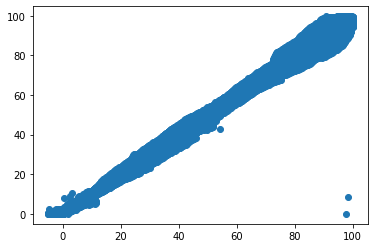

In [48]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

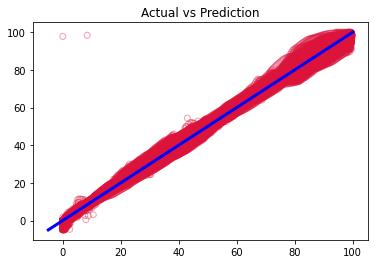

In [49]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

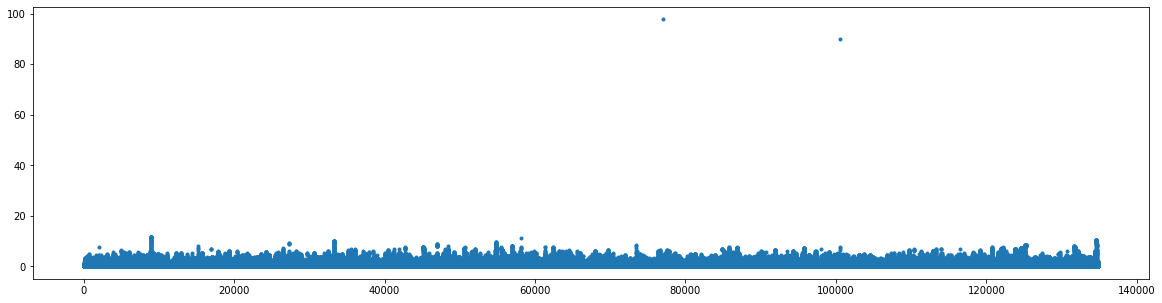

In [50]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')

In [51]:
for i in range(len(pred)):
    if (abs(actual[i]-pred[i]) > 50):
        print(i)

76953
100563


In [52]:
print('Predict: ', pred[33642])
print('Actual: ', actual[33642])

Predict:  [17.60957333]
Actual:  [17.81376518]


In [53]:
x_test[33642][:]

array([283.85872511,  85.43642398,   0.34275954,  92.26605589,
         0.        ,   0.        ,   0.        ,  45.        ])

***TESTING ON OTHER SUBJECT***

In [54]:
test_file_list = []

for i in range(len(test_sub)):
    test_file_list.append(pd.read_excel(excel_path + test_sub[i], sheet_name='Sheet1'))

In [55]:
## if there are multiple subject to test:
# random.shuffle(test_file_list)

all_test = pd.concat(test_file_list, axis = 0, ignore_index = True)

In [56]:
all_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194364 entries, 0 to 194363
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   n_lcop        194364 non-null  int64  
 1   n_rcop        194364 non-null  int64  
 2   l_ph_ank      194364 non-null  float64
 3   l_ph_hip      194364 non-null  float64
 4   l_ph_fo       194364 non-null  float64
 5   r_ph_ank      194364 non-null  float64
 6   r_ph_hip      194364 non-null  float64
 7   r_ph_fo       194364 non-null  float64
 8   n_lgrf        194364 non-null  float64
 9   n_r_grf       194364 non-null  float64
 10  st_sw_phase   194364 non-null  int64  
 11  perc_new      194364 non-null  float64
 12  strike_frame  194364 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 19.3 MB


In [57]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_test) - 1):
    if (all_test['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_test.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
test_table = pd.concat(cycle_list, axis=0, ignore_index=True)

test_table

,n_lcop,n_rcop,l_ph_ank,l_ph_hip,l_ph_fo,r_ph_ank,r_ph_hip,r_ph_fo,n_lgrf,n_r_grf,st_sw_phase,perc_new,strike_frame
0,0,0,0.0,342.804539,1.027770,359.999929,289.035542,336.105757,0.128418,2.745381,0,0.000000,1
1,0,0,0.0,341.799388,1.588726,359.999938,284.544224,337.704767,0.213301,2.739484,0,0.440529,2
2,0,0,0.0,340.711989,2.158977,359.999949,281.475809,339.618571,0.320300,2.727851,0,0.881057,3
3,0,0,0.0,339.532444,2.729835,359.999961,279.224884,341.877891,0.449154,2.709782,0,1.321586,4
4,0,0,0.0,338.251820,3.292356,359.999973,277.479573,344.509830,0.597155,2.684732,0,1.762115,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193302,0,0,0.0,358.915983,319.286085,0.000000,267.304049,311.075749,0.000000,2.787521,0,97.706422,214
193303,0,0,0.0,357.722552,321.609088,0.000000,266.032857,310.928158,0.000000,2.800608,0,98.165138,215
193304,0,0,0.0,356.508919,324.698181,0.000000,264.447601,310.918455,0.000000,2.810026,0,98.623853,216
193305,0,0,0.0,355.264847,328.695560,0.000000,262.334871,311.067391,0.000000,2.815034,0,99.082569,217


In [58]:
test_table = test_table.drop(drop_list, axis = 1)
test_table

,n_lcop,n_rcop,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,st_sw_phase,perc_new,strike_frame
0,0,0,342.804539,1.027770,289.035542,336.105757,0,0.000000,1
1,0,0,341.799388,1.588726,284.544224,337.704767,0,0.440529,2
2,0,0,340.711989,2.158977,281.475809,339.618571,0,0.881057,3
3,0,0,339.532444,2.729835,279.224884,341.877891,0,1.321586,4
4,0,0,338.251820,3.292356,277.479573,344.509830,0,1.762115,5
...,...,...,...,...,...,...,...,...,...
193302,0,0,358.915983,319.286085,267.304049,311.075749,0,97.706422,214
193303,0,0,357.722552,321.609088,266.032857,310.928158,0,98.165138,215
193304,0,0,356.508919,324.698181,264.447601,310.918455,0,98.623853,216
193305,0,0,355.264847,328.695560,262.334871,311.067391,0,99.082569,217


In [59]:
x_test = test_table
x_test = x_test.drop(['perc_new'], axis=1)
scaler2 = MinMaxScaler()
x_test_scaled = scaler2.fit_transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled)

encode_gait_percentage(test_table, 'perc_new')
y_test = test_table[["X","Y"]]
y_test

data_x_test = x_test_scaled


In [60]:
#data_y_test = y_test.values.reshape(-1, 2)
data_y_test = y_test.values

In [61]:
test_x, test_y = convert_data(data_x_test, data_y_test, look_back, fore_cast)

In [62]:
check_point = data_x_test[11:]
check_point.shape

(193296, 8)

In [63]:
print(test_x.shape)

(193296, 10, 8)


In [64]:
test_encoded = encoder.predict(test_x)

6041/6041 [==============================] - 19s 3ms/step


In [65]:
print('Encoded time-series shape', test_encoded.shape)
print('Encoded time-series sample', test_encoded[0])

Encoded time-series shape (193296, 32)
Encoded time-series sample [-0.12908196 -0.06801602 -0.6477081  -0.27397376  0.1349312  -0.1971845
 -0.281459    0.08277236  0.33297864  0.19243178  0.600784   -0.22272453
 -0.5938231   0.3973869  -0.25201082  0.01769524  0.33424956 -0.20533383
 -0.6532042   0.74948967  0.00618509 -0.24816501  0.20941818 -0.6611872
 -0.13935825 -0.3882118  -0.08367836 -0.4935888  -0.21639916  0.6705563
 -0.25781858  0.62679034]


In [66]:
test_encoded_reshape = test_encoded

crossPredict = mlp_model.predict(test_encoded_reshape)

6041/6041 [==============================] - 5s 813us/step


In [67]:
crossPredict.shape

(193296, 2)

In [68]:
crossScore = np.sqrt(mean_squared_error(test_y, crossPredict))
print('Cross Subject Score: %.2f RMSE' % (crossScore))

Cross Subject Score: 0.90 RMSE


In [69]:

check_point_test = scaler.inverse_transform(check_point)

predict = np.zeros((len(crossPredict),1))

for iter in range(len(crossPredict)):
  x = crossPredict[iter][0]
  y = crossPredict[iter][1]
  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  if ((predict[iter] >= 80) & (check_point_test[iter][-1] <= 20)) :
    predict[iter] = predict[iter] - 100
    
    if abs(predict[iter]) >= 5:
        predict[iter] = 0


  if ((predict[iter] <= 20) & (check_point_test[iter][-1] >= 150)):
     predict[iter] = 100 - predict[iter]
     if abs(predict[iter]) >= 5:
         predict[iter] = 100

In [70]:
actual2 = np.zeros((len(test_y),1))

for iter in range(len(test_y)):
  x = test_y[iter][0]
  y = test_y[iter][1]
  actual2[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [71]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual2)):
    #if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      #correct+=1
      if (abs(actual2[iter] - predict[iter]) <= (i+1)):
        correct+=1

  print(correct)
  print(len(actual2))

  print("Precision ", i+1, ": ", correct * 100/len(actual2))

4805
193296
Precision  1 :  2.485824848936346
9483
193296
Precision  2 :  4.905947355351378
14049
193296
Precision  3 :  7.268127638440526
19200
193296
Precision  4 :  9.932952570151478
25003
193296
Precision  5 :  12.935084016223822


In [72]:
perc_rmse_cross = np.sqrt(mean_squared_error(actual2, predict))
print("Predicting Percentage RMSE: ", perc_rmse_cross)

Predicting Percentage RMSE:  31.63665511215101


In [73]:
rmse = 0
length = len(actual2)
for i in range(len(actual2)):

    rmse = rmse + pow(predict[i] - actual2[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual2))
print(rmse)

193296
193296
31.636655112150912


Text(0.5, 1.0, 'Actual vs Prediction')

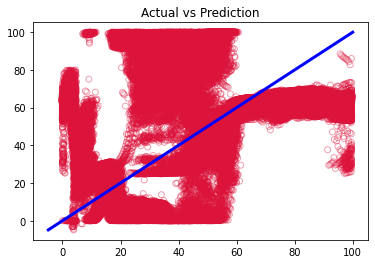

In [74]:
plt.scatter(actual2, predict, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(predict), max(actual2))
p2 = min(min(predict), min(actual2))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

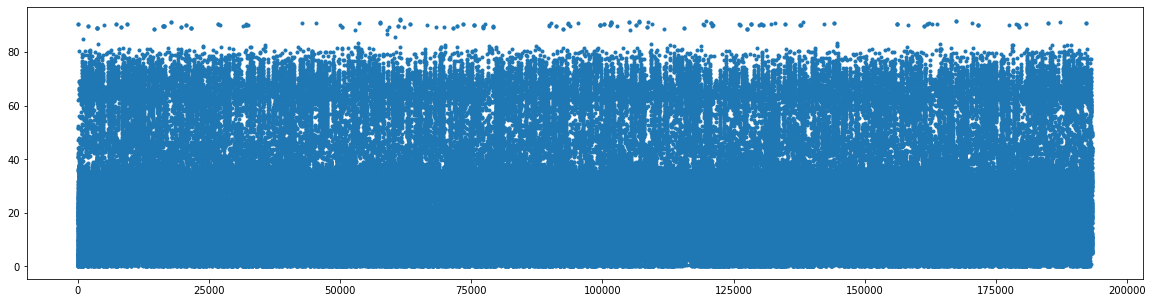

In [75]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual2-predict)

plt.plot(dif,'.')